## Model 6

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [9]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split(DATA, [0.9, 0.1])

In [10]:
train.shape, test.shape

((90009, 7), (9991, 7))

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
#from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

In [12]:
def Deep_MF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), 
                          embeddings_initializer='glorot_normal',
                          name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), 
                        embeddings_initializer='glorot_normal',
                          name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    Concat = Concatenate(name='Concat')([item_vec, user_vec])
    ConcatDrop = Dropout(0.5)(Concat)

    kernel_initializer='he_normal'
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(10, kernel_initializer='glorot_normal', name="Dense1")(ConcatDrop)
    Dense_1_Drop = Dropout(0.5)(Dense_1)
    Dense_2 = Dense(1, kernel_initializer='glorot_normal', name="Dense2")(Dense_1_Drop)

    
    AddBias = Add(name="AddBias")([Dense_2, item_bias_vec, user_bias_vec])
    
    
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    return model

In [13]:
n_factors = 50
model = Deep_MF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 50)        84100       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 50)        47150       User[0][0]                       
______________________________________________________________________________________________

In [17]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=15, verbose=1, 
                   validation_data= ([test.USER, test.ITEM], test.RATING))

Epoch 1/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8807 - val_loss: 0.8884
Epoch 2/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8728 - val_loss: 0.8859
Epoch 3/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8730 - val_loss: 0.8869
Epoch 4/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8682 - val_loss: 0.8849
Epoch 5/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8657 - val_loss: 0.8847
Epoch 6/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8638 - val_loss: 0.8881
Epoch 7/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8624 - val_loss: 0.8863
Epoch 8/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8614 - val_loss: 0.8865
Epoch 9/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8592 - val_loss: 0.8862
Epoch 10/15
704/704 [==============================] - 1s 1ms/step - loss: 0.8577 - val_loss: 0.8860

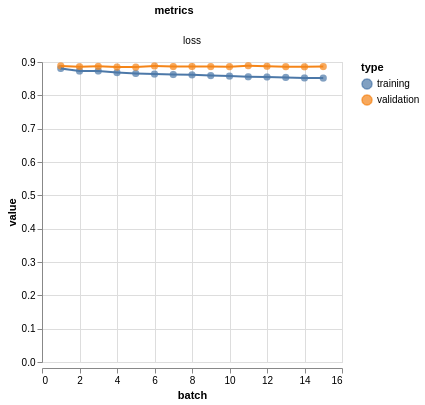

In [18]:
vis.metrics(output.history)

In [19]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

313/313 [==============================] - 0s 452us/step - loss: 0.8863


0.886265218257904

In [20]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [21]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [22]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 25.1 s, sys: 1.8 s, total: 26.9 s
Wall time: 17.7 s


In [23]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.109621
1,195,301,4.268870
2,195,376,2.342550
3,195,50,3.471423
4,195,345,3.812472


In [24]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 27.5 s, sys: 1.94 s, total: 29.4 s
Wall time: 20.1 s


In [25]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.008873
Precision@K:	0.007635
Recall@K:	0.005810


In [26]:
from reco.recommend import get_similar, show_similar

In [27]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 106 ms


In [28]:
item_similar_indices

array([[   0, 1646, 1456, 1525,  710],
       [   1, 1681, 1656, 1626, 1618],
       [   2, 1432, 1509,  856, 1309],
       ...,
       [1679, 1383, 1654, 1582, 1349],
       [1680, 1541, 1446, 1504, 1669],
       [1681, 1640, 1593, 1625, 1365]])

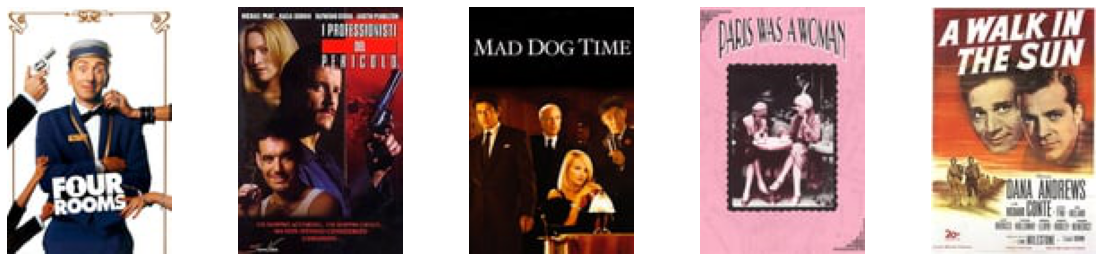

In [30]:
show_similar(2, item_similar_indices, item_encoder)